# Use DQN to Play MoutainCar-v0

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools
import copy

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(0)

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('MountainCar-v0')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

22:50:18 [INFO] env: <MountainCarEnv<MountainCar-v0>>
22:50:18 [INFO] action_space: Discrete(3)
22:50:18 [INFO] observation_space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
22:50:18 [INFO] reward_range: (-inf, inf)
22:50:18 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 30}
22:50:18 [INFO] _max_episode_steps: 200
22:50:18 [INFO] _elapsed_steps: None


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class DQNAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.replayer = DQNReplayer(10000)

        self.evaluate_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[64, 64], output_size=self.action_n)
        self.optimizer = optim.Adam(self.evaluate_net.parameters(), lr=0.001)
        self.loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        model = nn.Sequential(*layers)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.target_net = copy.deepcopy(self.evaluate_net)

    def step(self, observation, reward, done):
        if self.mode == 'train' and np.random.rand() < 0.001:
            # epsilon-greedy policy in train mode
            action = np.random.randint(self.action_n)
        else:
            state_tensor = torch.as_tensor(observation,
                    dtype=torch.float).squeeze(0)
            q_tensor = self.evaluate_net(state_tensor)
            action_tensor = torch.argmax(q_tensor)
            action = action_tensor.item()
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, action, next_state, reward, done, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, action, reward, next_state, done)
            if self.replayer.count >= self.replayer.capacity * 0.95:
                    # skip first few episodes for speed
                self.learn()
        return action

    def close(self):
        pass

    def learn(self):
        # replay
        states, actions, rewards, next_states, dones = \
                self.replayer.sample(1024) # replay transitions
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.long)
        reward_tensor = torch.as_tensor(rewards, dtype=torch.float)
        next_state_tensor = torch.as_tensor(next_states, dtype=torch.float)
        done_tensor = torch.as_tensor(dones, dtype=torch.float)

        # train
        next_q_tensor = self.target_net(next_state_tensor)
        next_max_q_tensor, _ = next_q_tensor.max(axis=-1)
        target_tensor = reward_tensor + self.gamma * (1. - done_tensor) * next_max_q_tensor
        pred_tensor = self.evaluate_net(state_tensor)
        q_tensor = pred_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        loss_tensor = self.loss(target_tensor, q_tensor)
        self.optimizer.zero_grad()
        loss_tensor.backward()
        self.optimizer.step()


agent = DQNAgent(env)

22:50:18 [INFO] ==== train ====
22:50:19 [DEBUG] train episode 0: reward = -200.00, steps = 200
22:50:19 [DEBUG] train episode 1: reward = -200.00, steps = 200
22:50:19 [DEBUG] train episode 2: reward = -200.00, steps = 200
22:50:19 [DEBUG] train episode 3: reward = -200.00, steps = 200
22:50:19 [DEBUG] train episode 4: reward = -200.00, steps = 200
22:50:20 [DEBUG] train episode 5: reward = -200.00, steps = 200
22:50:20 [DEBUG] train episode 6: reward = -200.00, steps = 200
22:50:20 [DEBUG] train episode 7: reward = -200.00, steps = 200
22:50:20 [DEBUG] train episode 8: reward = -200.00, steps = 200
22:50:20 [DEBUG] train episode 9: reward = -200.00, steps = 200
22:50:20 [DEBUG] train episode 10: reward = -200.00, steps = 200
22:50:21 [DEBUG] train episode 11: reward = -200.00, steps = 200
22:50:21 [DEBUG] train episode 12: reward = -200.00, steps = 200
22:50:21 [DEBUG] train episode 13: reward = -200.00, steps = 200
22:50:21 [DEBUG] train episode 14: reward = -200.00, steps = 200
22:

00:06:38 [DEBUG] train episode 126: reward = -200.00, steps = 200
00:07:23 [DEBUG] train episode 127: reward = -200.00, steps = 200
00:08:09 [DEBUG] train episode 128: reward = -200.00, steps = 200
00:08:54 [DEBUG] train episode 129: reward = -200.00, steps = 200
00:09:39 [DEBUG] train episode 130: reward = -200.00, steps = 200
00:10:23 [DEBUG] train episode 131: reward = -200.00, steps = 200
00:11:08 [DEBUG] train episode 132: reward = -200.00, steps = 200
00:11:52 [DEBUG] train episode 133: reward = -200.00, steps = 200
00:12:37 [DEBUG] train episode 134: reward = -200.00, steps = 200
00:13:23 [DEBUG] train episode 135: reward = -200.00, steps = 200
00:14:05 [DEBUG] train episode 136: reward = -200.00, steps = 200
00:14:47 [DEBUG] train episode 137: reward = -200.00, steps = 200
00:15:33 [DEBUG] train episode 138: reward = -200.00, steps = 200
00:16:17 [DEBUG] train episode 139: reward = -200.00, steps = 200
00:17:02 [DEBUG] train episode 140: reward = -200.00, steps = 200
00:17:48 [

01:21:03 [DEBUG] train episode 251: reward = -200.00, steps = 200
01:21:29 [DEBUG] train episode 252: reward = -200.00, steps = 200
01:21:54 [DEBUG] train episode 253: reward = -200.00, steps = 200
01:22:20 [DEBUG] train episode 254: reward = -200.00, steps = 200
01:22:45 [DEBUG] train episode 255: reward = -200.00, steps = 200
01:23:10 [DEBUG] train episode 256: reward = -200.00, steps = 200
01:23:36 [DEBUG] train episode 257: reward = -200.00, steps = 200
01:24:00 [DEBUG] train episode 258: reward = -200.00, steps = 200
01:24:26 [DEBUG] train episode 259: reward = -200.00, steps = 200
01:24:51 [DEBUG] train episode 260: reward = -200.00, steps = 200
01:25:18 [DEBUG] train episode 261: reward = -200.00, steps = 200
01:25:44 [DEBUG] train episode 262: reward = -200.00, steps = 200
01:26:10 [DEBUG] train episode 263: reward = -200.00, steps = 200
01:26:35 [DEBUG] train episode 264: reward = -200.00, steps = 200
01:27:01 [DEBUG] train episode 265: reward = -200.00, steps = 200
01:27:27 [

01:45:35 [DEBUG] train episode 376: reward = -200.00, steps = 200
01:45:43 [DEBUG] train episode 377: reward = -200.00, steps = 200
01:45:51 [DEBUG] train episode 378: reward = -200.00, steps = 200
01:45:59 [DEBUG] train episode 379: reward = -200.00, steps = 200
01:46:07 [DEBUG] train episode 380: reward = -200.00, steps = 200
01:46:16 [DEBUG] train episode 381: reward = -200.00, steps = 200
01:46:24 [DEBUG] train episode 382: reward = -200.00, steps = 200
01:46:32 [DEBUG] train episode 383: reward = -200.00, steps = 200
01:46:40 [DEBUG] train episode 384: reward = -200.00, steps = 200
01:46:48 [DEBUG] train episode 385: reward = -200.00, steps = 200
01:46:56 [DEBUG] train episode 386: reward = -200.00, steps = 200
01:47:04 [DEBUG] train episode 387: reward = -200.00, steps = 200
01:47:12 [DEBUG] train episode 388: reward = -200.00, steps = 200
01:47:20 [DEBUG] train episode 389: reward = -200.00, steps = 200
01:47:28 [DEBUG] train episode 390: reward = -200.00, steps = 200
01:47:37 [

02:02:36 [DEBUG] train episode 501: reward = -200.00, steps = 200
02:02:44 [DEBUG] train episode 502: reward = -200.00, steps = 200
02:02:52 [DEBUG] train episode 503: reward = -200.00, steps = 200
02:03:00 [DEBUG] train episode 504: reward = -200.00, steps = 200
02:03:08 [DEBUG] train episode 505: reward = -200.00, steps = 200
02:03:16 [DEBUG] train episode 506: reward = -200.00, steps = 200
02:03:25 [DEBUG] train episode 507: reward = -200.00, steps = 200
02:03:33 [DEBUG] train episode 508: reward = -200.00, steps = 200
02:03:41 [DEBUG] train episode 509: reward = -200.00, steps = 200
02:03:49 [DEBUG] train episode 510: reward = -200.00, steps = 200
02:03:57 [DEBUG] train episode 511: reward = -200.00, steps = 200
02:04:06 [DEBUG] train episode 512: reward = -200.00, steps = 200
02:04:14 [DEBUG] train episode 513: reward = -200.00, steps = 200
02:04:22 [DEBUG] train episode 514: reward = -200.00, steps = 200
02:04:30 [DEBUG] train episode 515: reward = -200.00, steps = 200
02:04:38 [

02:19:33 [DEBUG] train episode 626: reward = -200.00, steps = 200
02:19:41 [DEBUG] train episode 627: reward = -200.00, steps = 200
02:19:49 [DEBUG] train episode 628: reward = -200.00, steps = 200
02:19:58 [DEBUG] train episode 629: reward = -200.00, steps = 200
02:20:06 [DEBUG] train episode 630: reward = -200.00, steps = 200
02:20:14 [DEBUG] train episode 631: reward = -200.00, steps = 200
02:20:22 [DEBUG] train episode 632: reward = -200.00, steps = 200
02:20:30 [DEBUG] train episode 633: reward = -200.00, steps = 200
02:20:39 [DEBUG] train episode 634: reward = -200.00, steps = 200
02:20:47 [DEBUG] train episode 635: reward = -200.00, steps = 200
02:20:55 [DEBUG] train episode 636: reward = -200.00, steps = 200
02:21:03 [DEBUG] train episode 637: reward = -200.00, steps = 200
02:21:11 [DEBUG] train episode 638: reward = -200.00, steps = 200
02:21:20 [DEBUG] train episode 639: reward = -200.00, steps = 200
02:21:28 [DEBUG] train episode 640: reward = -200.00, steps = 200
02:21:36 [

02:36:29 [DEBUG] train episode 751: reward = -200.00, steps = 200
02:36:37 [DEBUG] train episode 752: reward = -200.00, steps = 200
02:36:45 [DEBUG] train episode 753: reward = -200.00, steps = 200
02:36:53 [DEBUG] train episode 754: reward = -200.00, steps = 200
02:37:02 [DEBUG] train episode 755: reward = -200.00, steps = 200
02:37:10 [DEBUG] train episode 756: reward = -200.00, steps = 200
02:37:18 [DEBUG] train episode 757: reward = -200.00, steps = 200
02:37:26 [DEBUG] train episode 758: reward = -200.00, steps = 200
02:37:34 [DEBUG] train episode 759: reward = -200.00, steps = 200
02:37:42 [DEBUG] train episode 760: reward = -200.00, steps = 200
02:37:50 [DEBUG] train episode 761: reward = -200.00, steps = 200
02:37:59 [DEBUG] train episode 762: reward = -200.00, steps = 200
02:38:07 [DEBUG] train episode 763: reward = -200.00, steps = 200
02:38:15 [DEBUG] train episode 764: reward = -200.00, steps = 200
02:38:19 [DEBUG] train episode 765: reward = -107.00, steps = 107
02:38:27 [

02:52:13 [DEBUG] train episode 876: reward = -200.00, steps = 200
02:52:21 [DEBUG] train episode 877: reward = -200.00, steps = 200
02:52:28 [DEBUG] train episode 878: reward = -169.00, steps = 169
02:52:35 [DEBUG] train episode 879: reward = -170.00, steps = 170
02:52:43 [DEBUG] train episode 880: reward = -200.00, steps = 200
02:52:50 [DEBUG] train episode 881: reward = -172.00, steps = 172
02:52:57 [DEBUG] train episode 882: reward = -166.00, steps = 166
02:53:04 [DEBUG] train episode 883: reward = -163.00, steps = 163
02:53:10 [DEBUG] train episode 884: reward = -153.00, steps = 153
02:53:17 [DEBUG] train episode 885: reward = -162.00, steps = 162
02:53:23 [DEBUG] train episode 886: reward = -155.00, steps = 155
02:53:30 [DEBUG] train episode 887: reward = -161.00, steps = 161
02:53:38 [DEBUG] train episode 888: reward = -192.00, steps = 192
02:53:44 [DEBUG] train episode 889: reward = -161.00, steps = 161
02:53:53 [DEBUG] train episode 890: reward = -200.00, steps = 200
02:54:01 [

03:06:23 [DEBUG] train episode 1001: reward = -200.00, steps = 200
03:06:31 [DEBUG] train episode 1002: reward = -200.00, steps = 200
03:06:37 [DEBUG] train episode 1003: reward = -147.00, steps = 147
03:06:43 [DEBUG] train episode 1004: reward = -136.00, steps = 136
03:06:48 [DEBUG] train episode 1005: reward = -126.00, steps = 126
03:06:51 [DEBUG] train episode 1006: reward = -86.00, steps = 86
03:06:58 [DEBUG] train episode 1007: reward = -150.00, steps = 150
03:07:02 [DEBUG] train episode 1008: reward = -100.00, steps = 100
03:07:08 [DEBUG] train episode 1009: reward = -149.00, steps = 149
03:07:12 [DEBUG] train episode 1010: reward = -94.00, steps = 94
03:07:17 [DEBUG] train episode 1011: reward = -132.00, steps = 132
03:07:26 [DEBUG] train episode 1012: reward = -200.00, steps = 200
03:07:31 [DEBUG] train episode 1013: reward = -121.00, steps = 121
03:07:36 [DEBUG] train episode 1014: reward = -121.00, steps = 121
03:07:39 [DEBUG] train episode 1015: reward = -86.00, steps = 86
0

03:09:20 [DEBUG] test episode 93: reward = -111.00, steps = 111
03:09:20 [DEBUG] test episode 94: reward = -103.00, steps = 103
03:09:20 [DEBUG] test episode 95: reward = -106.00, steps = 106
03:09:20 [DEBUG] test episode 96: reward = -128.00, steps = 128
03:09:21 [DEBUG] test episode 97: reward = -179.00, steps = 179
03:09:21 [DEBUG] test episode 98: reward = -105.00, steps = 105
03:09:21 [DEBUG] test episode 99: reward = -110.00, steps = 110
03:09:21 [INFO] average episode reward = -108.55 ± 26.06


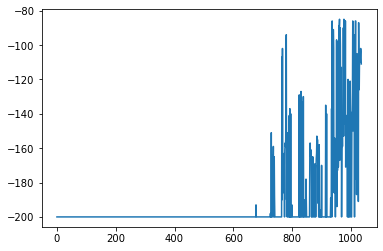

In [5]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -110:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [6]:
env.close()